<a href="https://colab.research.google.com/github/240609/MLF/blob/main/RecurrentNN/TimeSeriesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.0 Import Libraries + 1.1 Generating dataset**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, SimpleRNN
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential

def generate_time_series(batch_size, n_steps):
  freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
  time = np.linspace(0,1,n_steps)

  series = 0.5 * np.sin((time - offsets1) * (freq1*10 + 10))
  series += 0.2 * np.sin((time - offsets2) * (freq2*20 + 20))
  series += 0.1 * (np.random.rand(batch_size, n_steps)- 0.5)
  return series[..., np.newaxis].astype(np.float32)

data_size = 10000
n_steps = 50
np.random.seed(0)

series = generate_time_series(data_size, n_steps + 1)

**1.2 Train/Valid/Test split**

In [2]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

no_training_epochs = 5

**1.3 Data examination**

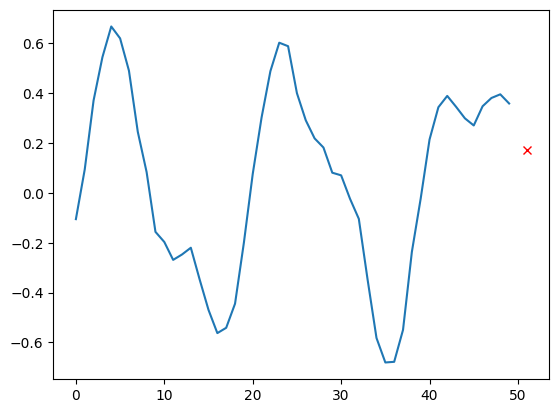

In [3]:
plt.figure()
plt.plot(X_train[0])
plt.plot(n_steps+1, y_train[0], 'rx')

**1.4 Simple Linear model**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1104 - mean_squared_error: 0.1104 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Test loss: 0.008910524658858776
Test MSE:  0.008910524658858776


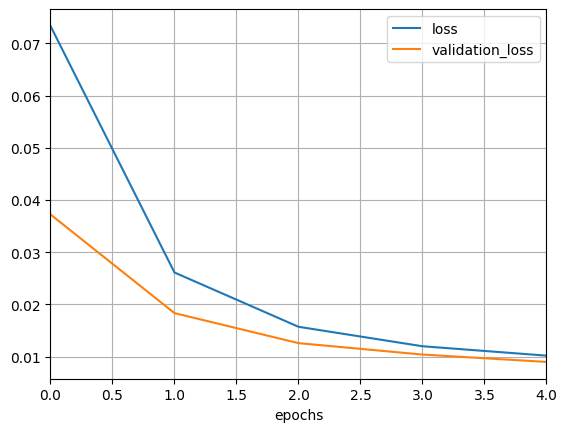

In [4]:
# Model definition
model_linear = Sequential()
model_linear.add(Flatten(input_shape=(50,1)))
model_linear.add(Dense(1, activation = None))

# Model building
learning_rate = 0.001
optimizer = Adam(learning_rate)
model_linear.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])

model_linear.summary()

# Model training
history_linear = model_linear.fit(X_train, y_train, epochs=no_training_epochs, validation_data=[X_valid, y_valid])

def plot_function(history):
  plt.figure()

  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='validation_loss')
  plt.legend()
  plt.grid()
  plt.xlim([0,no_training_epochs-1])
  plt.xlabel('epochs')

plot_function(history_linear)

score = model_linear.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print(f'Test MSE: ', score[1])



**1.5 Simple RNN Model**

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3007 - mean_squared_error: 0.3007 - val_loss: 0.2042 - val_mean_squared_error: 0.2042
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1663 - mean_squared_error: 0.1663 - val_loss: 0.0941 - val_mean_squared_error: 0.0941
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0745 - mean_squared_error: 0.0745 - val_loss: 0.0519 - val_mean_squared_error: 0.0519
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0484 - mean_squared_error: 0.0484 - val_loss: 0.0420 - val_mean_squared_error: 0.0420
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0375 - val_mean_squared_error: 0.0375


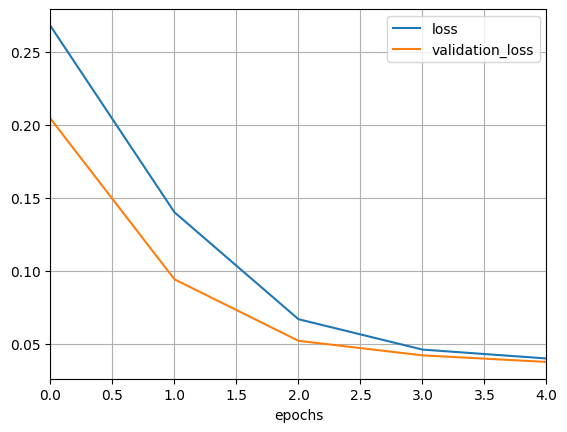

In [7]:
model_simple_rnn = Sequential()
model_simple_rnn.add(SimpleRNN(1, input_shape=[50, 1]))

learning_rate_simple_rnn = 0.001
optimizer_simple_rnn = Adam(learning_rate_simple_rnn)
model_simple_rnn.compile(loss='mean_squared_error', optimizer=optimizer_simple_rnn, metrics=['mean_squared_error'])

history_simple_rnn = model_simple_rnn.fit(X_train, y_train, epochs=no_training_epochs, validation_data=[X_valid, y_valid])

plot_function(history_simple_rnn)



**1.6 Deep RNN Model**

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Test loss: 0.0031771929934620857
Test MSE:  0.0031771929934620857


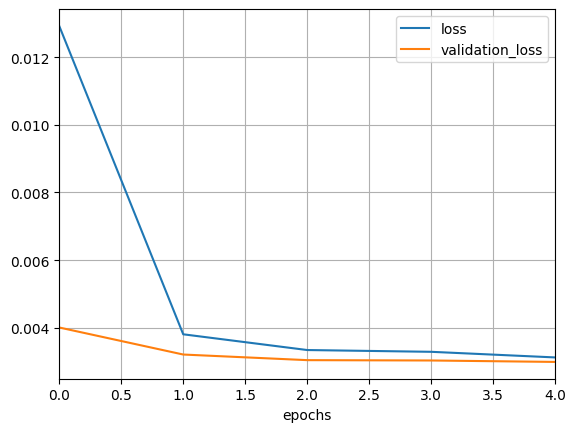

In [8]:
model_deep_rnn = Sequential()
model_deep_rnn.add(SimpleRNN(20, return_sequences = True, input_shape=[50, 1]))
model_deep_rnn.add(SimpleRNN(20, return_sequences = True))
model_deep_rnn.add(SimpleRNN(1, input_shape=[50, 1]))

learning_rate_deep_rnn = 0.001
optimizer_deep_rnn = Adam(learning_rate_deep_rnn)
model_deep_rnn.compile(loss='mean_squared_error', optimizer=optimizer_deep_rnn, metrics=['mean_squared_error'])

history_deep_rnn = model_deep_rnn.fit(X_train, y_train, epochs=no_training_epochs, validation_data=[X_valid, y_valid])

score = model_deep_rnn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print(f'Test MSE: ', score[1])

plot_function(history_deep_rnn)